# Bibliotecas

In [280]:
#!pip uninstall keras -y

In [281]:
#!pip install tensorflow==2.15.0
#!pip install keras==2.15.0

In [282]:
import warnings
warnings.filterwarnings('ignore')

In [283]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os

from pathlib import Path
import pandas as pd

import pickle

from sklearn.model_selection import train_test_split
import tensorflow as tf

import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import Model
from keras.optimizers import Adam

import time

In [284]:
print(tf.__version__)

2.15.0


In [285]:
print(keras.__version__)

2.15.0


# Pré-processamento

In [286]:
train_folder=r"C:\Users\CPQD\Documents\dataset_balanceado\train"
val_folder=r"C:\Users\CPQD\Documents\dataset_balanceado\val"
test_folder=r"C:\Users\CPQD\Documents\dataset_balanceado\test" 

In [287]:
train_generator = ImageDataGenerator (preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                      #validation_split=0.2 # o subset ja esta separado
                                      )

test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [288]:
train_images = train_generator.flow_from_directory(
    directory=train_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    #subset='training' # o subset de treino ja esta separado
)

val_images = train_generator.flow_from_directory(
    directory=val_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    #subset='validation'
)

test_images = test_generator.flow_from_directory(
    directory=test_folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 5036 images belonging to 12 classes.
Found 1085 images belonging to 12 classes.
Found 1077 images belonging to 12 classes.


# Modelo: ResNet50

In [289]:
pretrained_model=tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    #classes=12,
    classifier_activation="softmax",
)

In [290]:
pretrained_model.trainable = False

In [291]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

checkpoint_path = r"C:\Users\CPQD\Documents\vscode\teste1\resnet50_v2.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True, # default eh False
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [292]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True)

In [293]:
inputs=pretrained_model.inputs
x = tf.keras.layers.Dense(256,activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

In [294]:
from keras import Model

model=Model(inputs,outputs)

In [295]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.5)

In [296]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

# Treinamento

In [297]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
315/315 [==============================] - 309s 969ms/step - loss: 1.2151 - accuracy: 0.6227 - val_loss: 0.4196 - val_accuracy: 0.8811
Epoch 2/50
315/315 [==============================] - 226s 717ms/step - loss: 0.4244 - accuracy: 0.8705 - val_loss: 0.2957 - val_accuracy: 0.8959
Epoch 3/50
315/315 [==============================] - 235s 746ms/step - loss: 0.2873 - accuracy: 0.9130 - val_loss: 0.2518 - val_accuracy: 0.9152
Epoch 4/50
315/315 [==============================] - 234s 745ms/step - loss: 0.2204 - accuracy: 0.9329 - val_loss: 0.2146 - val_accuracy: 0.9272
Epoch 5/50
315/315 [==============================] - 233s 739ms/step - loss: 0.1686 - accuracy: 0.9452 - val_loss: 0.2204 - val_accuracy: 0.9272
Epoch 6/50
315/315 [==============================] - 234s 742ms/step - loss: 0.1263 - accuracy: 0.9639 - val_loss: 0.2036 - val_accuracy: 0.9355
Epoch 7/50
315/315 [==============================] - 235s 748ms/step - loss: 0.1169 - accuracy: 0.9635 - val_loss: 0.2047 -

In [298]:
model.save(r"C:\Users\CPQD\Documents\vscode\teste1\resnet50_v2.keras")

# Teste

In [299]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.21320
Test Accuracy: 93.31%


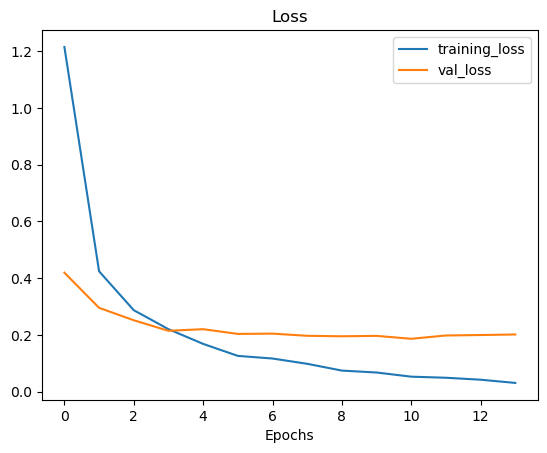

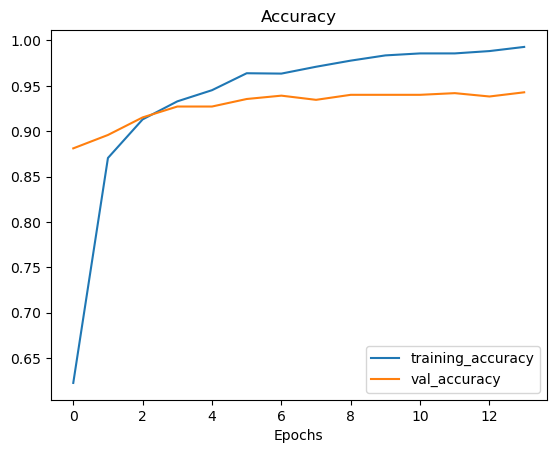

In [300]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

# Tempo de inferência

In [301]:
import time

start=time.time()

pred_og=model.predict(test_images)

end=time.time()

68/68 [==============================] - 42s 605ms/step


In [302]:
pred=np.argmax(pred_og,axis=1)

In [303]:
media=(end-start)/1077
print("Tempo de inferência médio: "+str(media)+" segundos")

Tempo de inferência médio: 0.03949033317459659 segundos


# TensorFlow Lite

In [304]:
def representative_dataset_generator():
    for _ in range(100):
        data = next(val_images)[0]
        yield [data.astype(np.float32)]

In [305]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [306]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset =  representative_dataset_generator
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8 

In [307]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\CPQD\AppData\Local\Temp\tmphyc0a5kd\assets


INFO:tensorflow:Assets written to: C:\Users\CPQD\AppData\Local\Temp\tmphyc0a5kd\assets


In [308]:
with open(r"C:\Users\CPQD\Documents\vscode\teste1\resnet50_v2.tflite", "wb") as f:
    f.write(tflite_model)

In [309]:
!cd C:\Users\CPQD\Documents\vscode\teste1\

In [310]:
os.system("xxd -i resnet50_v2.tflite > resnet50_v2.cc")

1

In [311]:
TF_MODEL_FILE_PATH=r"C:\Users\CPQD\Documents\vscode\teste1\resnet50_v2.tflite"
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [333]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['input_3'], 'outputs': ['dense_8']}}

In [313]:
classify_lite = interpreter.get_signature_runner('serving_default')

# Pré-processar dataset inédito

In [314]:
folder=r"C:\Users\CPQD\Documents\dataset_novo"

In [315]:
generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [316]:
images = generator.flow_from_directory(
    directory=folder,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1,
    shuffle=True,
    seed=42,
)

Found 48 images belonging to 12 classes.


## Observar objeto gerado pelo ImageDataGenerator

In [317]:
images[47][0]

array([[[[ 58.060997 ,  41.221    ,  41.32     ],
         [ 48.060997 ,  34.221    ,  32.32     ],
         [ 46.060997 ,  33.221    ,  31.32     ],
         ...,
         [104.061    ,  83.221    ,  79.32     ],
         [106.061    ,  83.221    ,  80.32     ],
         [108.061    ,  85.221    ,  82.32     ]],

        [[ 70.061    ,  53.221    ,  51.32     ],
         [ 64.061    ,  49.221    ,  46.32     ],
         [ 65.061    ,  49.221    ,  47.32     ],
         ...,
         [103.061    ,  82.221    ,  79.32     ],
         [102.061    ,  81.221    ,  78.32     ],
         [107.061    ,  86.221    ,  83.32     ]],

        [[ 77.061    ,  59.221    ,  57.32     ],
         [ 71.061    ,  54.221    ,  52.32     ],
         [ 72.061    ,  55.221    ,  53.32     ],
         ...,
         [103.061    ,  82.221    ,  79.32     ],
         [102.061    ,  81.221    ,  78.32     ],
         [107.061    ,  86.221    ,  83.32     ]],

        ...,

        [[ 22.060997 ,  24.221    ,  3

In [318]:
len(images) # retorna quantidade de imagens

48

In [319]:
len(images[47]) # imagem e rótulo

2

In [320]:
len(images[47][0]) # batch size

1

In [321]:
len(images[47][0][0]) # altura

224

In [322]:
len(images[47][0][0][0]) # largura

224

In [323]:
len(images[47][0][0][0][0]) # canais

3

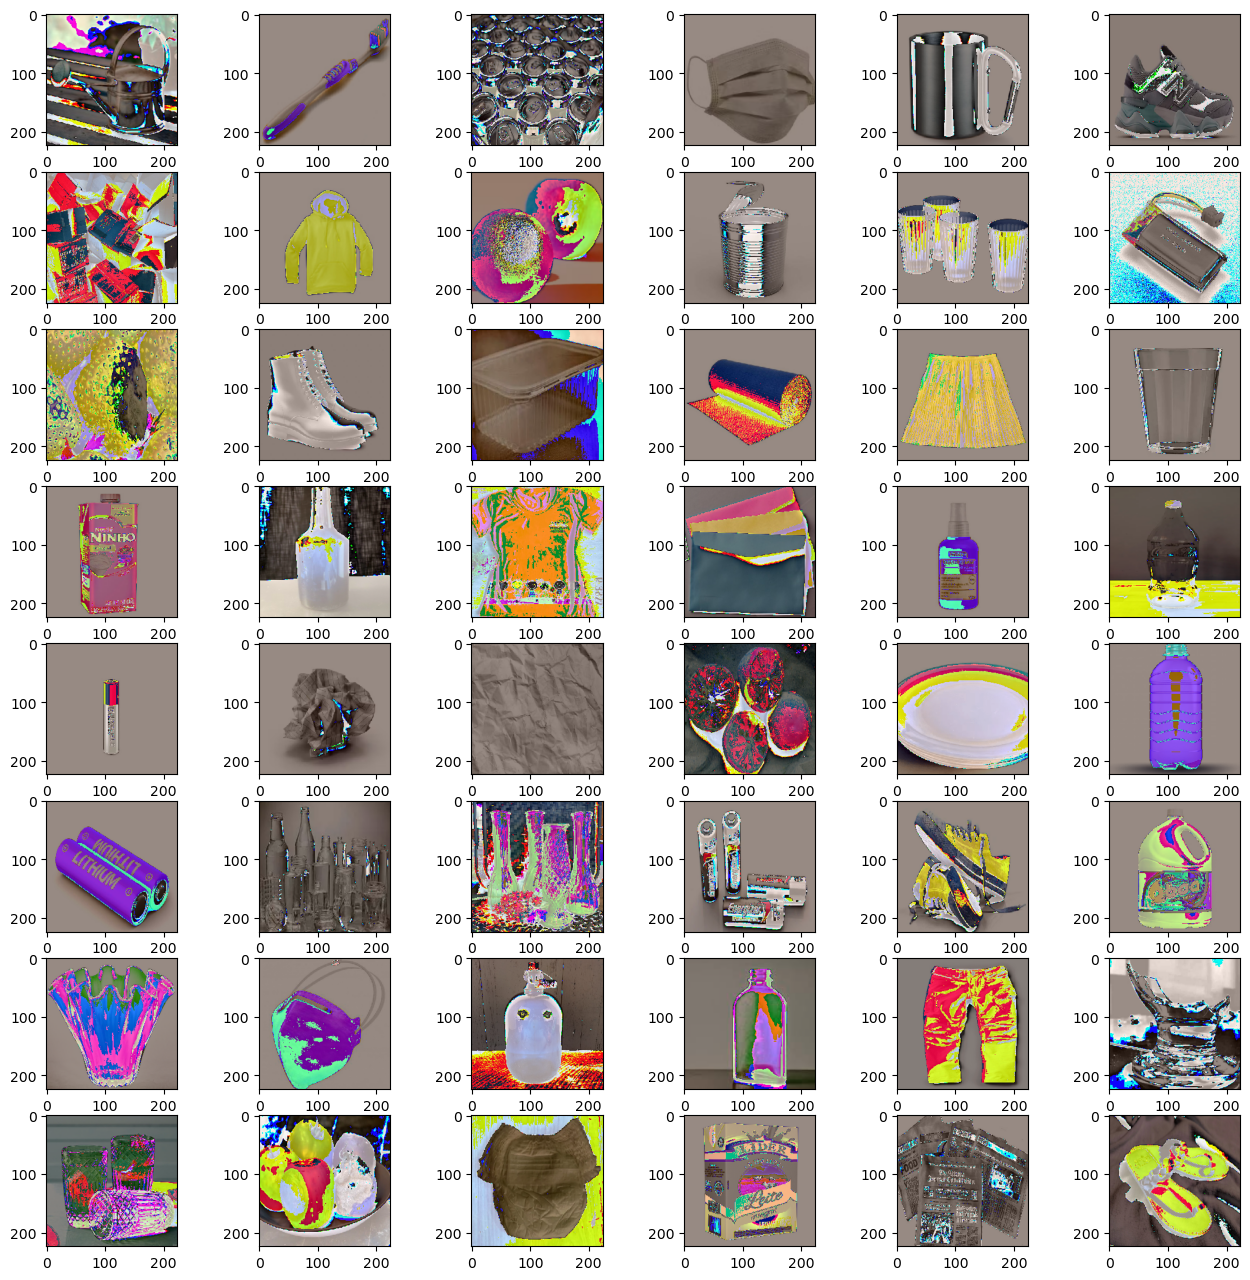

In [324]:
plt.figure(figsize=(16, 16))
for i in range(1,len(images)+1):
   plt.subplot(8, 6, i)
   batch = images[i-1][0] #images.next()[0]
   image_ = batch[0].astype("uint8")
   plt.imshow(image_)
plt.show()

In [325]:
images[0][0]

array([[[[ -65.939    ,  -74.779    ,  -89.68     ],
         [ -66.939    ,  -75.779    ,  -93.68     ],
         [ -66.939    ,  -75.779    ,  -93.68     ],
         ...,
         [ -96.939    ,  -85.779    , -102.68     ],
         [ -89.939    ,  -83.779    ,  -99.68     ],
         [ -81.939    ,  -76.779    ,  -92.68     ]],

        [[ -62.939003 ,  -69.779    ,  -86.68     ],
         [ -65.939    ,  -71.779    ,  -91.68     ],
         [ -65.939    ,  -71.779    ,  -91.68     ],
         ...,
         [ -98.939    ,  -87.779    , -103.68     ],
         [ -91.939    ,  -87.779    , -102.68     ],
         [ -83.939    ,  -82.779    ,  -97.68     ]],

        [[ -60.939003 ,  -66.779    ,  -84.68     ],
         [ -62.939003 ,  -68.779    ,  -89.68     ],
         [ -63.939003 ,  -68.779    ,  -89.68     ],
         ...,
         [ -97.939    ,  -85.779    , -102.68     ],
         [ -91.939    ,  -86.779    , -102.68     ],
         [ -85.939    ,  -83.779    ,  -99.68     ]],

In [330]:
img=images[0][0].astype("int8") # com uint8 o modelo quebra, pois foi feito p/int8

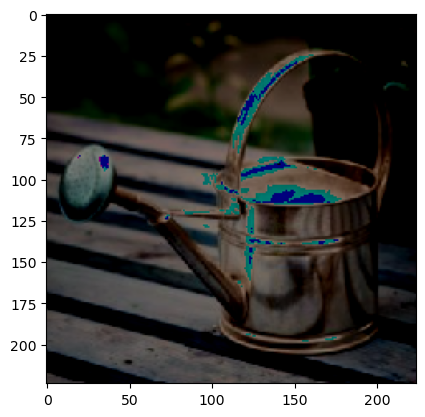

In [331]:
plt.imshow(img[0])
plt.show()

# Testar modelo quantizado

## Primeira imagem

In [334]:
predictions_lite = classify_lite(input_3=img) #['outputs']

In [335]:
predictions_lite

{'dense_8': array([[-128,  120, -128, -128, -128, -128, -124, -128, -128, -128, -126,
         -128]], dtype=int8)}

In [336]:
(k, v), = predictions_lite.items()

In [337]:
v

array([[-128,  120, -128, -128, -128, -128, -124, -128, -128, -128, -126,
        -128]], dtype=int8)

In [338]:
np.argmax(v)

1

In [339]:
v_f=v/255.0 # a entrada p/softmax precisa ser float 

In [340]:
v_f

array([[-0.50196078,  0.47058824, -0.50196078, -0.50196078, -0.50196078,
        -0.50196078, -0.48627451, -0.50196078, -0.50196078, -0.50196078,
        -0.49411765, -0.50196078]])

In [341]:
score_lite = tf.nn.softmax(v_f)

In [342]:
score_lite 

<tf.Tensor: shape=(1, 12), dtype=float64, numpy=
array([[0.07316166, 0.19348898, 0.07316166, 0.07316166, 0.07316166,
        0.07316166, 0.07431834, 0.07316166, 0.07316166, 0.07316166,
        0.07373773, 0.07316166]])>

In [343]:
np.argmax(score_lite)

1

errou: marcou biological, mas era metal

In [344]:
images.class_indices

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

## Segunda imagem

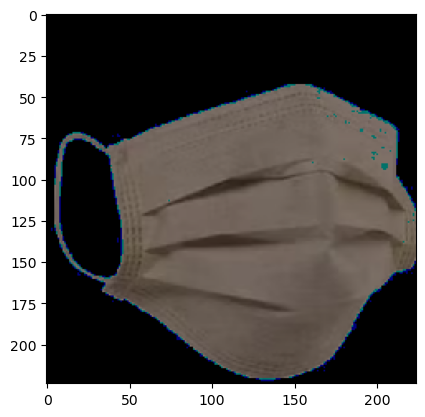

In [346]:
img=images[3][0].astype("int8")
plt.imshow(img[0])
plt.show()

In [347]:
predictions_lite = classify_lite(input_3=img)

In [348]:
predictions_lite

{'dense_8': array([[-128, -128, -128, -128, -128, -128, -128, -128, -128, -128,  127,
         -128]], dtype=int8)}

In [349]:
(k, v), = predictions_lite.items()

In [350]:
np.argmax(v)

10

In [351]:
v_f=v/255.0
score_lite = tf.nn.softmax(v_f)
print(score_lite)
print("class: ", np.argmax(score_lite))

tf.Tensor(
[[0.07289543 0.07289543 0.07289543 0.07289543 0.07289543 0.07289543
  0.07289543 0.07289543 0.07289543 0.07289543 0.19815031 0.07289543]], shape=(1, 12), dtype=float64)
class:  10


acertou (trash).

## Terceira imagem

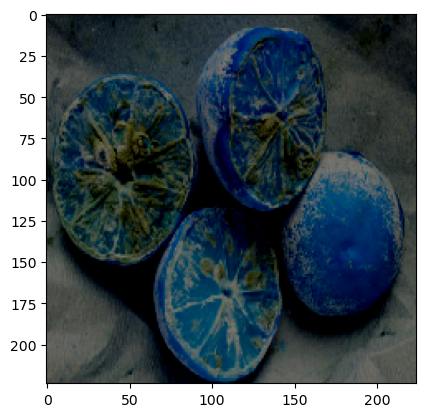

In [352]:
img=images[27][0].astype("int8")
plt.imshow(img[0])
plt.show()

In [353]:
predictions_lite = classify_lite(input_3=img)

In [354]:
(k, v), = predictions_lite.items()

In [355]:
v

array([[-128,  115, -128, -126, -128, -128, -120, -126, -127, -128, -128,
        -128]], dtype=int8)

In [356]:
v_f=v/255.0
score_lite = tf.nn.softmax(v_f)
print(score_lite)
print("class: ", np.argmax(score_lite))

tf.Tensor(
[[0.0732876  0.19005863 0.0732876  0.07386467 0.0732876  0.0732876
  0.07562327 0.07386467 0.07357557 0.0732876  0.0732876  0.0732876 ]], shape=(1, 12), dtype=float64)
class:  1


acertou (biological).

## Todas as imagens

In [372]:
pred=[]
rotulo=[]
for i in range(len(images)):
    img=images[i][0].astype("int8")
    predictions_lite = classify_lite(input_3=img)
    (k, v), = predictions_lite.items()
    pred.append(np.argmax(v))
    r=np.where(images[i][1] == 1)[1]
    rotulo.append(r.item())

In [380]:
a=0
e=[]
for i in range(len(pred)):
    if(pred[i]==rotulo[i]):
        a=a+1
    else:
        e.append(i)

In [381]:
a

38

In [382]:
e

[0, 6, 14, 15, 17, 25, 26, 28, 31, 37]

In [384]:
for i in range(len(e)):
    print("predicao: ", pred[e[i]])
    print("rotulo: ", rotulo[e[i]])
    print("- - - - -")

predicao:  1
rotulo:  6
- - - - -
predicao:  7
rotulo:  3
- - - - -
predicao:  6
rotulo:  8
- - - - -
predicao:  1
rotulo:  3
- - - - -
predicao:  2
rotulo:  11
- - - - -
predicao:  10
rotulo:  7
- - - - -
predicao:  1
rotulo:  7
- - - - -
predicao:  6
rotulo:  2
- - - - -
predicao:  10
rotulo:  11
- - - - -
predicao:  1
rotulo:  10
- - - - -
